In [2]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines
from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner
from transformers.trainer_callback import TrainerCallback
import itertools
import sys
from IPython.display import clear_output

In [3]:
model_name = "EleutherAI/pythia-70m"
# Get the current directory
current_directory = os.getcwd()
# Join the folder path
folder_path = os.path.join(current_directory, "content")
dataset_name = "ai-medical-chatbot_processed.jsonl"
dataset_path = os.path.join(folder_path, dataset_name)
#dataset_path = f"/content/{dataset_name}"
use_hf = False
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)
base_model = AutoModelForCausalLM.from_pretrained(model_name)
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

2024-04-10 12:07:25,243 - DEBUG - utilities - Config: datasets.path: c:\Blog\How-to-Finetuning-Large-Language-Models\content\ai-medical-chatbot_processed.jsonl
datasets.use_hf: false
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize False c:\Blog\How-to-Finetuning-Large-Language-Models\content\ai-medical-chatbot_processed.jsonl


2024-04-10 12:07:25,573 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-f1c6af33428df321/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/dataset_info.json
2024-04-10 12:07:25,659 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-f1c6af33428df321/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/dataset_info.json
2024-04-10 12:07:26,627 - DEBUG - utilities - Select CPU device


In [4]:
from collections import Counter
import math

def cosine_similarity(str1, str2):
    """
    Computes the cosine similarity between two strings using the Bag-of-Words model.

    Args:
        str1: The first string.
        str2: The second string.

    Returns:
        A float representing the cosine similarity between the two strings.
    """
    # Tokenize the strings
    tokens1 = str1.split()
    tokens2 = str2.split()

    # Create bag of words for each string
    bow1 = Counter(tokens1)
    bow2 = Counter(tokens2)

    # Get the set of all unique words
    all_words = set(bow1.keys()).union(set(bow2.keys()))

    # Compute dot product
    dot_product = sum(bow1[word] * bow2[word] for word in all_words)

    # Compute magnitudes
    magnitude1 = math.sqrt(sum(bow1[word] ** 2 for word in all_words))
    magnitude2 = math.sqrt(sum(bow2[word] ** 2 for word in all_words))

    # Compute cosine similarity
    if magnitude1 == 0 or magnitude2 == 0:
        return 0
    else:
        return dot_product / (magnitude1 * magnitude2)


In [5]:
def inference_new(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=1000):
  # Tokenize
  input_ids = tokenizer.encode(
      text,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_tokens
  )

  # Generate
  device = model.device
  attention_mask = torch.ones_like(input_ids)  # Create mask with all 1s

  # Fix: Mask all padding tokens, including the first element
  attention_mask[input_ids == tokenizer.pad_token_id] = 0

  generated_tokens_with_prompt = model.generate(
      input_ids.to(device),
      max_length=max_output_tokens,
      attention_mask=attention_mask,
      pad_token_id=tokenizer.eos_token_id  # Set pad token
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]
  return generated_text_answer



In [6]:
from tqdm import tqdm
import pandas as pd
from transformers.trainer_callback import TrainerCallback
import matplotlib.pyplot as plt


class MetricsCollector(TrainerCallback):
    """
    Callback to collect metrics during training.

    This callback stores all the logs it receives during training in a list
    called `metrics`. This list can then be used to plot training loss, learning rate,
    and other metrics.
    """

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Stores the logs received during training.

        This method is called whenever the trainer logs information. It simply
        appends the entire `logs` dictionary to the `metrics` list.

        Args:
          args: Arguments passed to the trainer.
          state: State of the trainer.
          control: Control object for the trainer.
          logs: Dictionary containing the logged metrics. (optional)
          **kwargs: Additional keyword arguments.
        """
        self.metrics.append(logs)


import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

def plot_loss(metrics, output_dir):
    losses = [m.get('loss', None) for m in metrics]
    non_none_losses = [loss for loss in losses if loss is not None]
    plt.plot(non_none_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    file_path = os.path.join(output_dir, 'training_loss_plot.png')
    plt.savefig(file_path)
    plt.close()
    
    # Load the image as a NumPy array

    img = PILImage.open(file_path)
    img_array = np.array(img)
    
    return img_array

def plot_learning_rate(metrics, output_dir):
    learning_rates = [m.get('learning_rate', None) for m in metrics]
    non_none_learning_rates = [lr for lr in learning_rates if lr is not None]
    plt.plot(non_none_learning_rates)
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    file_path = os.path.join(output_dir, 'learning_rate_plot.png')
    plt.savefig(file_path)
    plt.close()

    # Load the image as a NumPy array

    img = PILImage.open(file_path)
    img_array = np.array(img)

    return img_array


2024-04-10 12:07:27,030 - DEBUG - matplotlib - matplotlib data path: c:\Blog\How-to-Finetuning-Large-Language-Models\.venv\lib\site-packages\matplotlib\mpl-data
2024-04-10 12:07:27,049 - DEBUG - matplotlib - CONFIGDIR=C:\Users\066226758\.matplotlib
2024-04-10 12:07:27,052 - DEBUG - matplotlib - interactive is False
2024-04-10 12:07:27,054 - DEBUG - matplotlib - platform is win32
2024-04-10 12:07:27,104 - DEBUG - matplotlib - CACHEDIR=C:\Users\066226758\.matplotlib
2024-04-10 12:07:27,115 - DEBUG - matplotlib.font_manager - Using fontManager instance from C:\Users\066226758\.matplotlib\fontlist-v330.json


In [7]:
from transformers import AutoModelForCausalLM
import shutil
def train_model(hyperparameters, delete=False, testing=False):
  max_steps = hyperparameters["max_steps"]
  # Convert hyperparameter values to integers and add them to the string
  hyperparameter_str = '_'.join(str(int(value)) if isinstance(value, (int, float)) else value for value in hyperparameters.values())
  # Create the trained_model_name variable
  trained_model_name = f"ai_medical_{hyperparameter_str}"

  #trained_model_name = f"ai_medical_{max_steps}_steps"
  output_dir = trained_model_name
  training_args = TrainingArguments(
    # Learning rate
    learning_rate=hyperparameters["learning_rate"],

    # Number of training epochs
    num_train_epochs=hyperparameters["num_train_epochs"],

    # Max steps to train for (each step is a batch of data)
    # Overrides num_train_epochs, if not -1
    max_steps=max_steps,

    # Batch size for training
    per_device_train_batch_size=hyperparameters["per_device_train_batch_size"],

    # Directory to save model checkpoints
    output_dir=output_dir,

    # Other arguments
    overwrite_output_dir=False, # Overwrite the content of the output directory
    disable_tqdm=False, # Disable progress bars
    eval_steps=120, # Number of update steps between two evaluations
    save_steps=120, # After # steps model is saved
    warmup_steps=1, # Number of warmup steps for learning rate scheduler
    per_device_eval_batch_size=1, # Batch size for evaluation
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=1,
    optim=hyperparameters["optim"],
    gradient_accumulation_steps = hyperparameters['gradient_accumulation_steps'],
    gradient_checkpointing=False,
    # Parameters for early stopping
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    greater_is_better=False
  )
  base_model.to(device)
  model_flops = (
    base_model.floating_point_ops(
      {
        "input_ids": torch.zeros(
            (1, training_config["model"]["max_length"])
        )
      }
    )
    * training_args.gradient_accumulation_steps
  )

  #print(base_model)
  print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
  print("Flops", model_flops / 1e9, "GFLOPs")

  trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
  
  metrics_collector = MetricsCollector()
  trainer.add_callback(metrics_collector)

  training_output = trainer.train()
  # Evaluate the model
  eval_results = trainer.evaluate()

  # Adding Evaluation 
  save_dir = f'{output_dir}'
  trainer.save_model(save_dir)
  #print("Saved model to:", save_dir)
  finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)
  finetuned_slightly_model.to(device)
  test_question = test_dataset[0]['question']
  #print("Question input (test):", test_question)
  predicted_answer=inference_new(test_question, finetuned_slightly_model, tokenizer)
  #print("Finetuned slightly model's answer: ")
  #print(predicted_answer) 
  test_answer = test_dataset[0]['answer']
  #print("Target answer output (test):", test_answer)
  metric_cosine_similarity=cosine_similarity(test_answer, predicted_answer)
  #print("Cosine Similarity:", metric_cosine_similarity)

  image_loss =plot_loss(metrics_collector.metrics, output_dir)
  image_learning_rate =plot_learning_rate(metrics_collector.metrics, output_dir)

  # Deleting the folder to save space
  if delete:
    shutil.rmtree(save_dir)
    print("Deleted model folder:", save_dir)
  if testing:
    return eval_results, training_output, metric_cosine_similarity,test_question,test_answer,predicted_answer,image_loss,image_learning_rate

  else:
    return eval_results, training_output, metric_cosine_similarity


In [8]:
from IPython.display import display, Image
import numpy as np
from PIL import Image as PILImage

def display_images(image_array):
    # Convert the NumPy arrays to PIL images
    image = PILImage.fromarray(image_array)
    # Display the images in the notebook
    display(image)


In [9]:
hyperparameters={'learning_rate': 1e-06,
'num_train_epochs': 1,
'per_device_train_batch_size': 1,
'optim': 'adafactor',
'max_steps':3,
'gradient_accumulation_steps':2}

In [10]:
eval_results, training_output, metric_cosine_similarity,test_question,test_answer,predicted_answer,image_loss,image_learning_rate =train_model(hyperparameters, delete=True, testing=True)
clear_output()

In [11]:
#display_images(image_loss)
#display_images(image_learning_rate)

In [12]:
def image_to_bytes(img):
    """Convert an image to bytes."""
    with io.BytesIO() as buffer:
        img.save(buffer, 'PNG')
        return buffer.getvalue()



In [13]:
import pandas as pd
from IPython.display import HTML
from base64 import b64encode
import io

def images_to_dataframe(image_loss_array, image_learning_rate_array):
    # Convert the NumPy arrays to PIL images
    image_loss = PILImage.fromarray(image_loss_array)
    image_learning_rate = PILImage.fromarray(image_learning_rate_array)

    # Convert the images to base64
    image_loss_b64 = b64encode(image_to_bytes(image_loss)).decode('utf-8')
    image_learning_rate_b64 = b64encode(image_to_bytes(image_learning_rate)).decode('utf-8')

    # Create a pandas DataFrame with the base64 images
    data = {'Image Loss': [f'<img src="data:image/png;base64,{image_loss_b64}" />'],
            'Image Learning Rate': [f'<img src="data:image/png;base64,{image_learning_rate_b64}" />']}
    df = pd.DataFrame(data)

    # Display the DataFrame with HTML
    return HTML(df.to_html(escape=False))

,Image Loss,Image Learning Rate
0,,

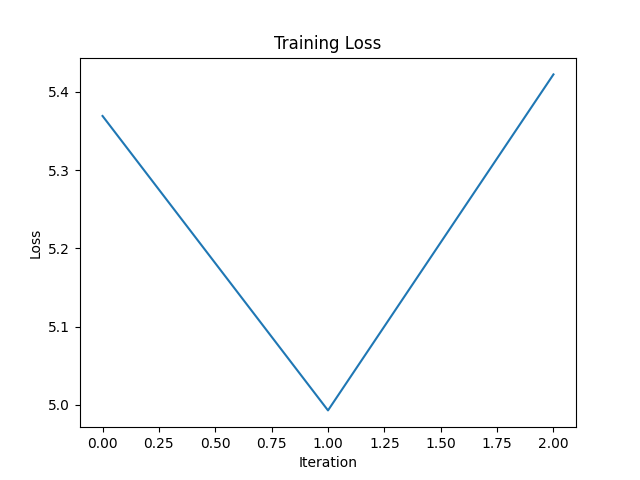
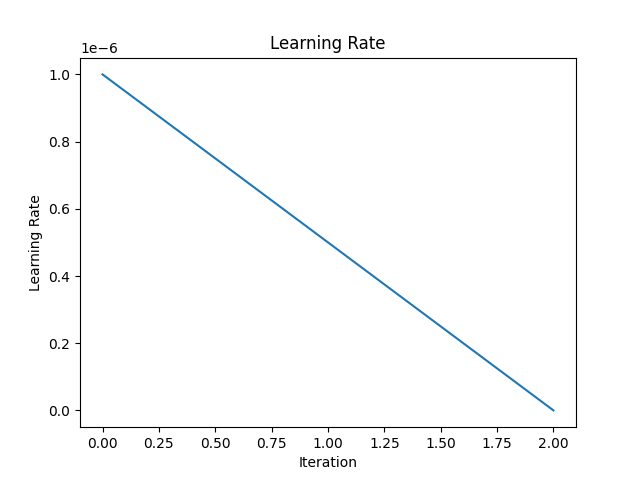

In [14]:
# Call the function with the image arrays
images_to_dataframe(image_loss, image_learning_rate)

In [15]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from ai-medical-chatbot: {test_dataset[0]['answer']}")
print("Model's answer: ")
#print(inference_new(test_text, base_model, tokenizer))

Question input (test): Will Kalarchikai cure multiple ovarian cysts in PCOD?
Correct answer from ai-medical-chatbot: Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulation study. Ovulation study is performed under the supervision of a gynecologist. For gall stones, surgical intervention is required generally. Medicine is not of much help.
Model's answer: 


In [16]:
def images_to_dict(image_loss_array, image_learning_rate_array):
    # Convert the NumPy arrays to PIL images
    image_loss = PILImage.fromarray(image_loss_array)
    image_learning_rate = PILImage.fromarray(image_learning_rate_array)

    # Convert the images to base64
    image_loss_b64 = b64encode(image_to_bytes(image_loss)).decode('utf-8')
    image_learning_rate_b64 = b64encode(image_to_bytes(image_learning_rate)).decode('utf-8')

    # Create a pandas DataFrame with the base64 images
    data = {'Image Loss': [f'<img src="data:image/png;base64,{image_loss_b64}" />'],
            'Image Learning Rate': [f'<img src="data:image/png;base64,{image_learning_rate_b64}" />']}
    return data

In [17]:
def images_to_b64(image_loss_array, image_learning_rate_array):
    # Convert the NumPy arrays to PIL images
    image_loss = PILImage.fromarray(image_loss_array)
    image_learning_rate = PILImage.fromarray(image_learning_rate_array)

    # Convert the images to base64
    image_loss_b64 = b64encode(image_to_bytes(image_loss)).decode('utf-8')
    image_learning_rate_b64 = b64encode(image_to_bytes(image_learning_rate)).decode('utf-8')

    # Create a pandas DataFrame with the base64 images
    data = {'Image Loss': [f'<img src="data:image/png;base64,{image_loss_b64}" />'],
            'Image Learning Rate': [f'<img src="data:image/png;base64,{image_learning_rate_b64}" />']}
    return data

In [18]:
def find_best_hyperparameters():
    best_hyperparameters = None
    best_loss = float('inf')
    # Lists to store data
    hyperparameters_list = []
    eval_results_list = []
    training_output_list = []
    cosine_similarity_list = []

    test_question_list = []
    test_answer_list = []
    predicted_answer_list = []

    image_loss_array_list = []
    image_learning_rate_array_list = []

    # Define hyperparameter search space
    hyperparameter_space = {
        "learning_rate": [1e-6, 1e-5, 1e-4],
        "num_train_epochs": [1,3,10],
        "per_device_train_batch_size": [1],
        "optim": ["adafactor"],
        "max_steps": [1,3,10],
        "gradient_accumulation_steps": [3],
    }
    # Generate all combinations of hyperparameters
    all_hyperparameters = list(itertools.product(*hyperparameter_space.values()))

    # Assuming all_hyperparameters is a list of hyperparameter combinations
    for hyperparameter_values in tqdm(all_hyperparameters):
        hyperparameters = dict(zip(hyperparameter_space.keys(), hyperparameter_values))
        
        # Evaluate the model
        # Print the current hyperparameters
        print("Using hyperparameters:")
        for key, value in hyperparameters.items():
            print(f"{key}: {value}")
        eval_results, training_output, metric_cosine_similarity, test_question, test_answer, predicted_answer,image_loss_array, image_learning_rate_array = train_model(hyperparameters,delete=True,testing=True)
        
        # Append data to lists
        hyperparameters_list.append(hyperparameters)
        eval_results_list.append(eval_results)
        training_output_list.append(training_output)
        cosine_similarity_list.append(metric_cosine_similarity)

        test_question_list.append(test_question)
        test_answer_list.append(test_answer)
        predicted_answer_list.append(predicted_answer)


        # Convert the NumPy arrays to PIL images
        image_loss = PILImage.fromarray(image_loss_array)
        image_learning_rate = PILImage.fromarray(image_learning_rate_array)

        # Convert the images to base64
        image_loss_b64 = b64encode(image_to_bytes(image_loss)).decode('utf-8')
        image_learning_rate_b64 = b64encode(image_to_bytes(image_learning_rate)).decode('utf-8')


        image_loss_array_list.append(f'<img src="data:image/png;base64,{image_loss_b64}" />')
        image_learning_rate_array_list.append(f'<img src="data:image/png;base64,{image_learning_rate_b64}" />')

        # Clear the output
        clear_output()
        # Check if this set of hyperparameters gives better results
        if eval_results["eval_loss"] < best_loss:
                best_loss = eval_results["eval_loss"]
                best_hyperparameters = hyperparameters

    # Create DataFrame
    data = {
        'Question':test_question_list,
        'Answer':test_answer_list,
        'Prediction':predicted_answer_list,
        'Hyperparameters': hyperparameters_list,
        'Evaluation Results': eval_results_list,
        'Training Output': training_output_list,
        'Cosine Similarity': cosine_similarity_list,
        'Image Loss': image_loss_array_list,
        'Image Learning Rate': image_learning_rate_array_list


    }
    df = pd.DataFrame(data)
    
    return best_hyperparameters, best_loss, df

In [19]:
# Call the function to find the best hyperparameters
best_hyperparameters, best_loss ,df = find_best_hyperparameters()

100%|██████████| 27/27 [16:39<00:00, 37.02s/it]


In [20]:
print("Best hyperparameters:", best_hyperparameters)
print("Best loss:", best_loss)

Best hyperparameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 1, 'optim': 'adafactor', 'max_steps': 10, 'gradient_accumulation_steps': 3}
Best loss: 3.0748367309570312


In [21]:
# Sort the DataFrame by 'eval_loss' inside the 'Evaluation Results' column
df_sorted = df.sort_values(by='Evaluation Results', 
                           key=lambda x: x.apply(lambda d: d['eval_loss']))

In [22]:
dataframe=df_sorted.head()
# Display the DataFrame with HTML
dataframe
#HTML(dataframe.to_html(escape=False))

,Question,Answer,Prediction,Hyperparameters,Evaluation Results,Training Output,Cosine Similarity,Image Loss,Image Learning Rate
18,Will Kalarchikai cure multiple ovarian cysts i...,Hello. I just read your query. See Kalarachi K...,Hi. For further doubts consult a sexologist on...,"{'learning_rate': 0.0001, 'num_train_epochs': ...","{'eval_loss': 3.0748367309570312, 'eval_runtim...","(1, 1.8949981927871704, {'train_runtime': 1.07...",0.006417,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
17,Will Kalarchikai cure multiple ovarian cysts i...,Hello. I just read your query. See Kalarachi K...,Hi. For further doubts consult a sexologist on...,"{'learning_rate': 1e-05, 'num_train_epochs': 1...","{'eval_loss': 3.0748367309570312, 'eval_runtim...","(10, 2.614243245124817, {'train_runtime': 11.8...",0.006417,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
16,Will Kalarchikai cure multiple ovarian cysts i...,Hello. I just read your query. See Kalarachi K...,Hi. For further information consult a urologis...,"{'learning_rate': 1e-05, 'num_train_epochs': 1...","{'eval_loss': 3.2251033782958984, 'eval_runtim...","(3, 1.9592613379160564, {'train_runtime': 3.30...",0.000831,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
15,Will Kalarchikai cure multiple ovarian cysts i...,Hello. I just read your query. See Kalarachi K...,Hi. For further doubts consult a gynecologist ...,"{'learning_rate': 1e-05, 'num_train_epochs': 1...","{'eval_loss': 3.2443389892578125, 'eval_runtim...","(1, 2.343248128890991, {'train_runtime': 1.179...",0.161181,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
14,Will Kalarchikai cure multiple ovarian cysts i...,Hello. I just read your query. See Kalarachi K...,Hi. For further doubts consult a gynecologist ...,"{'learning_rate': 1e-05, 'num_train_epochs': 3...","{'eval_loss': 3.2443389892578125, 'eval_runtim...","(10, 3.128424382209778, {'train_runtime': 13.1...",0.161181,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...","<img src=""data:image/png;base64,iVBORw0KGgoAAA..."


In [23]:
# Sort the DataFrame by 'Cosine Similarity' from largest to smallest
df_cos = df.sort_values(by='Cosine Similarity', ascending=False)

In [24]:
dataframe=df_cos[["Answer","Prediction","Cosine Similarity","Evaluation Results"]]
# Display the DataFrame with HTML
dataframe

,Answer,Prediction,Cosine Similarity,Evaluation Results
0,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases of ovaria...,0.334428,"{'eval_loss': 4.764142990112305, 'eval_runtime..."
1,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases of ovaria...,0.334428,"{'eval_loss': 4.735388278961182, 'eval_runtime..."
2,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases of ovaria...,0.334428,"{'eval_loss': 4.638494491577148, 'eval_runtime..."
3,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases of ovaria...,0.334428,"{'eval_loss': 4.638494491577148, 'eval_runtime..."
4,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases of ovaria...,0.334428,"{'eval_loss': 4.611077785491943, 'eval_runtime..."
11,Hello. I just read your query. See Kalarachi K...,\n\nI have a problem with a cyst in the perito...,0.324584,"{'eval_loss': 3.6434197425842285, 'eval_runtim..."
12,Hello. I just read your query. See Kalarachi K...,\n\nI have a problem with a cyst in the perito...,0.324584,"{'eval_loss': 3.6434197425842285, 'eval_runtim..."
5,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases. I have a...,0.224779,"{'eval_loss': 4.519514083862305, 'eval_runtime..."
6,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases. I have a...,0.224779,"{'eval_loss': 4.519514083862305, 'eval_runtime..."
7,Hello. I just read your query. See Kalarachi K...,\n\nI have a very long list of cases. I have a...,0.224779,"{'eval_loss': 4.492908477783203, 'eval_runtime..."



Method 2 (Styler object):


C:\Users\066226758\AppData\Local\Temp\ipykernel_38660\3492862490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Prediction'] = dataframe['Prediction'].apply(truncate_prediction)


,Image Loss,Image Learning Rate,Cosine Similarity,Prediction
0,,,0.334428,I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the litera...
1,,,0.334428,I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the litera...
2,,,0.334428,I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the litera...
3,,,0.334428,I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the litera...
4,,,0.334428,I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the literature. I have a very long list of cases of ovarian cyst in the litera...
11,,,0.324584,I have a problem with a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the pe...
12,,,0.324584,I have a problem with a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the peritoneal cavity. I have a cyst in the pe...
5,,,0.224779,I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of c...
6,,,0.224779,I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of c...
7,,,0.224779,I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of cases. I have a very long list of c...

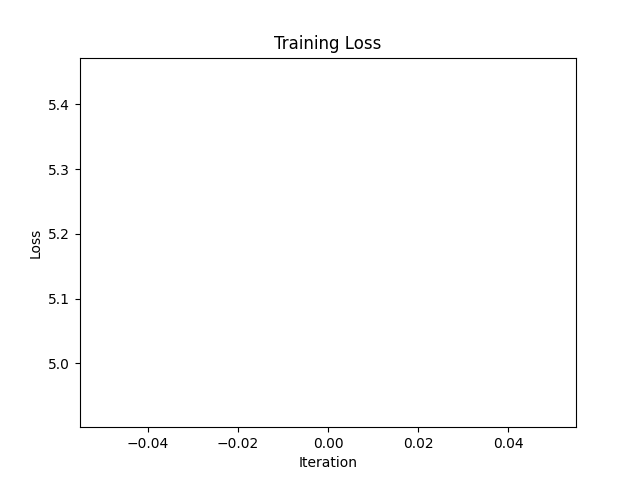
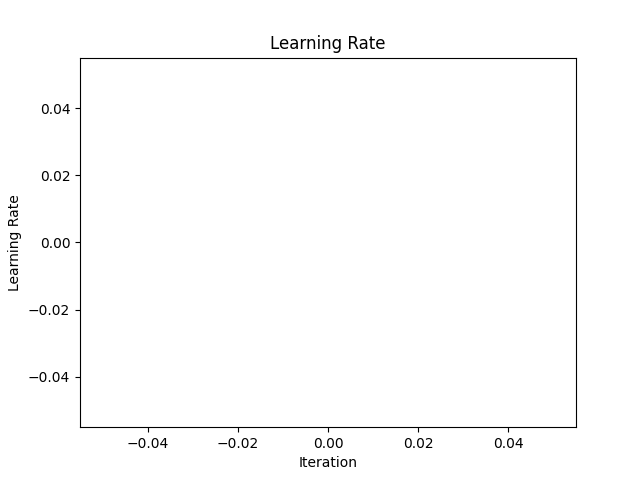
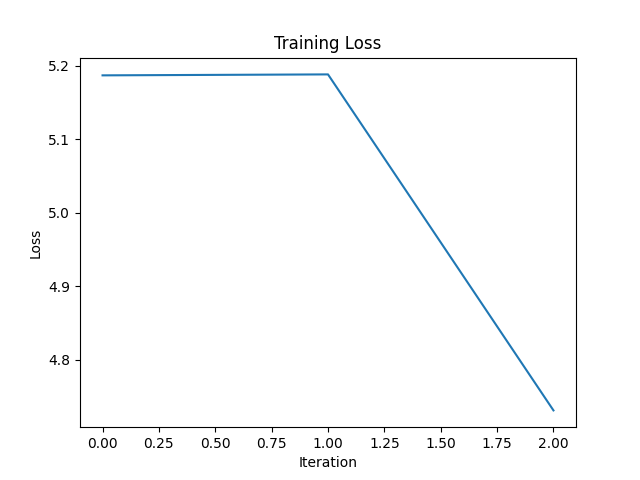
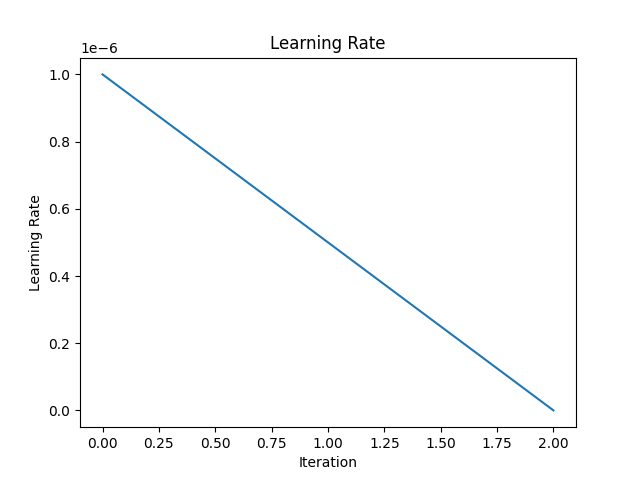
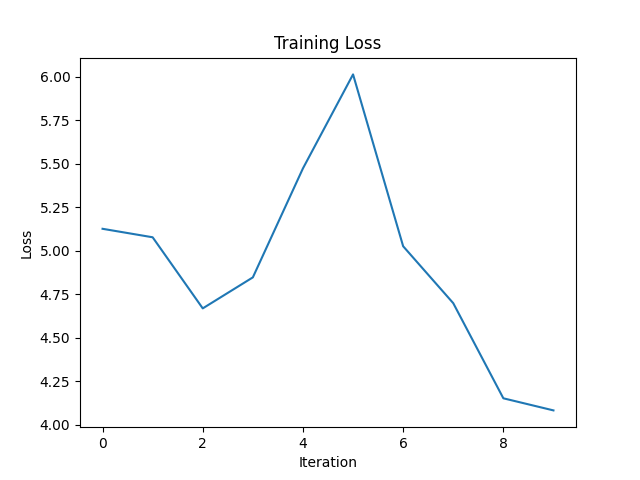
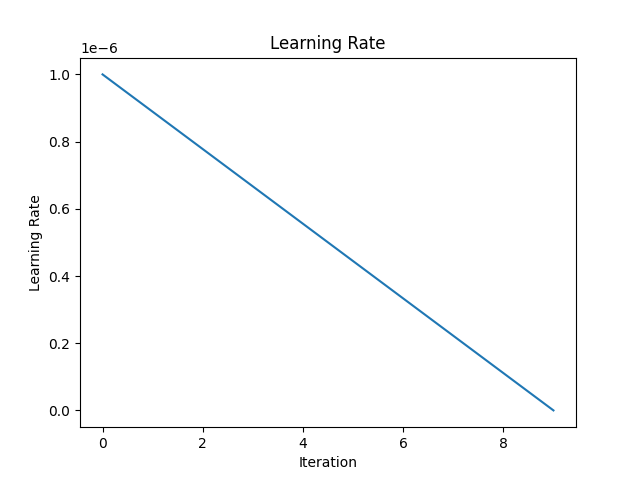
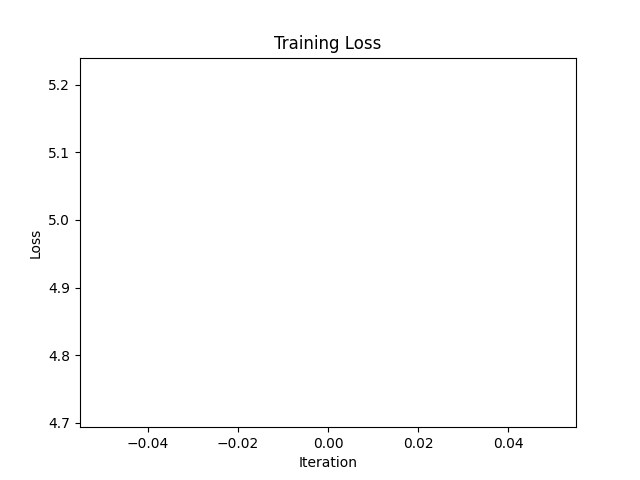
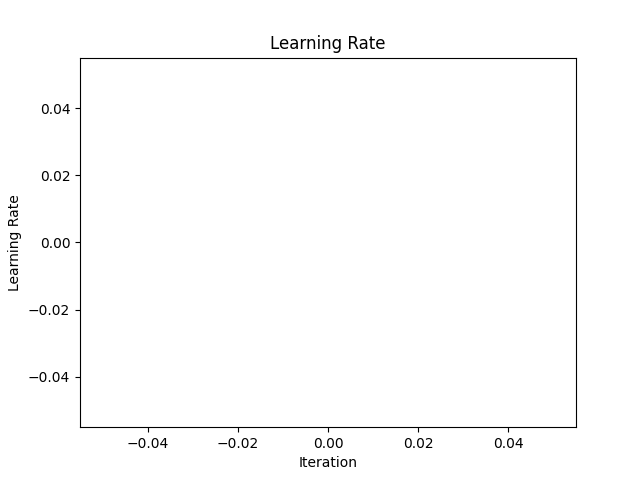
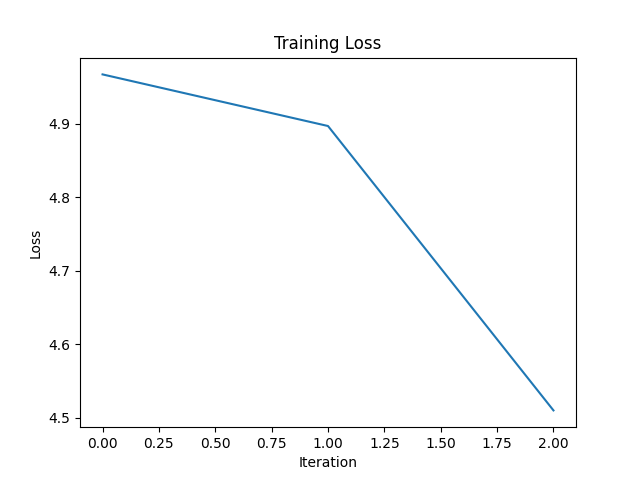
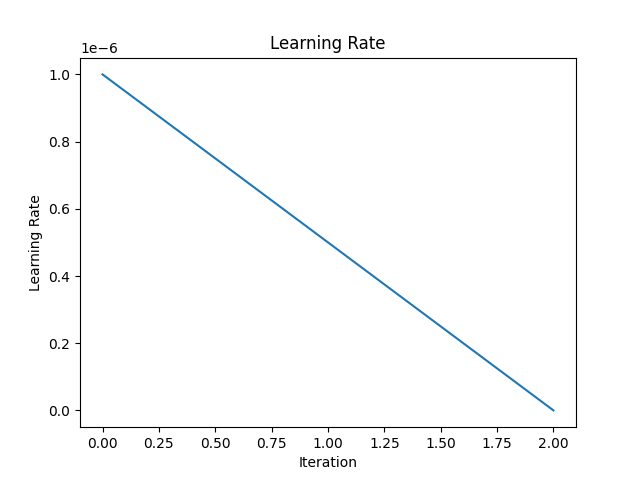
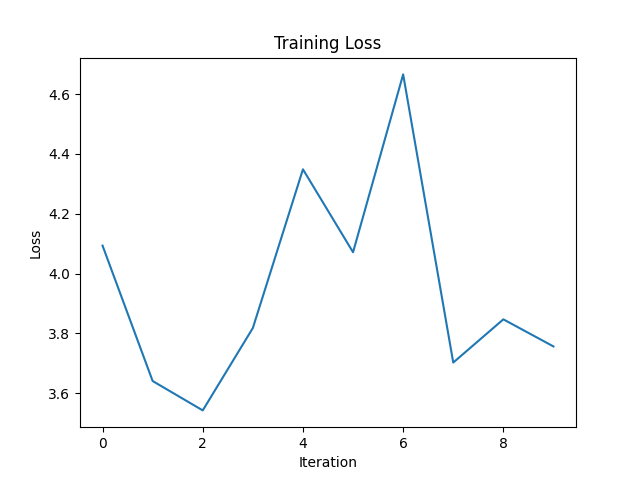
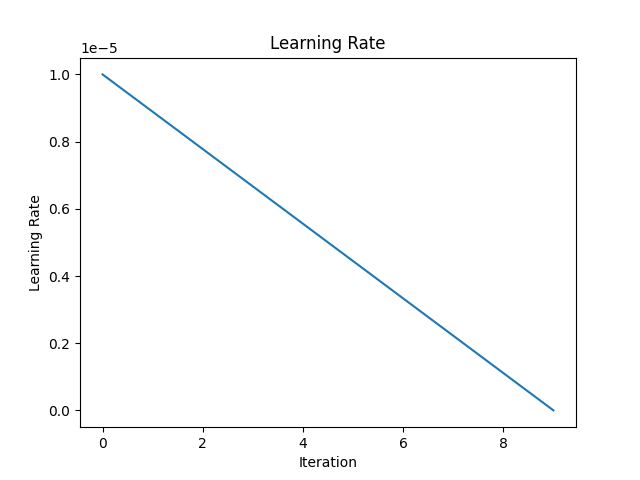
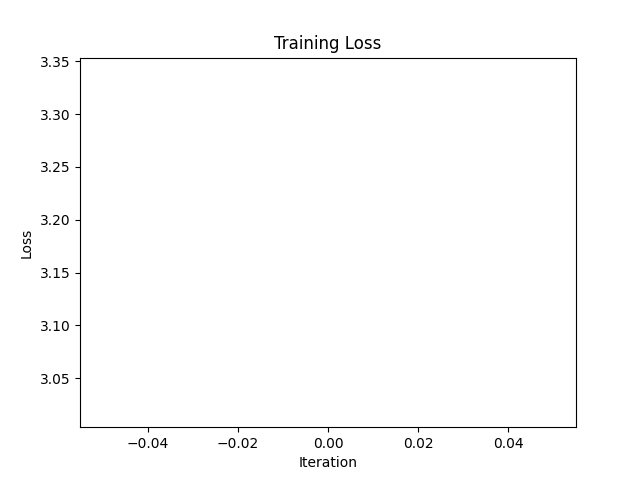
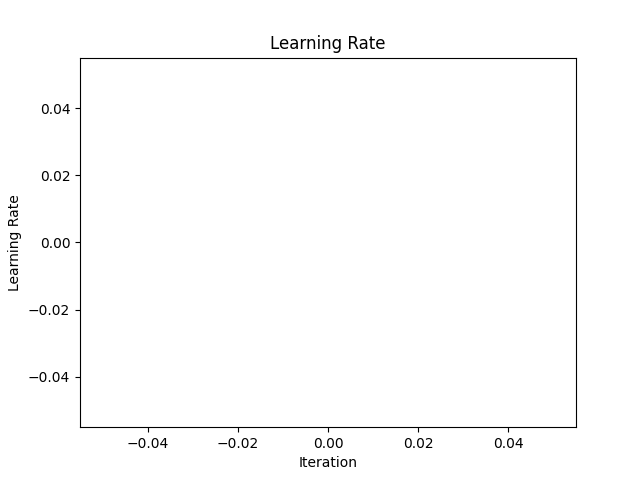
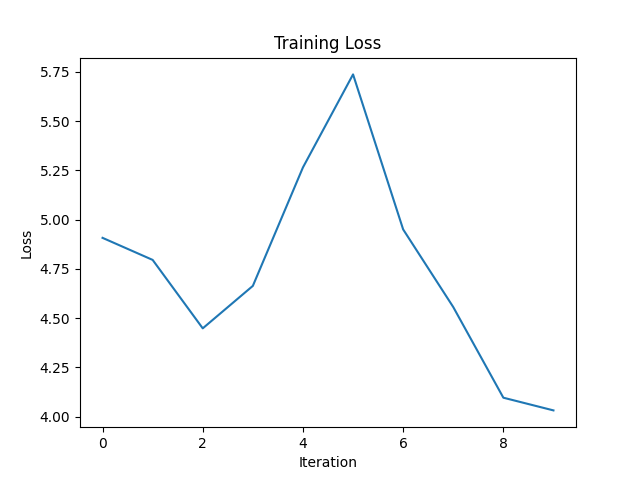
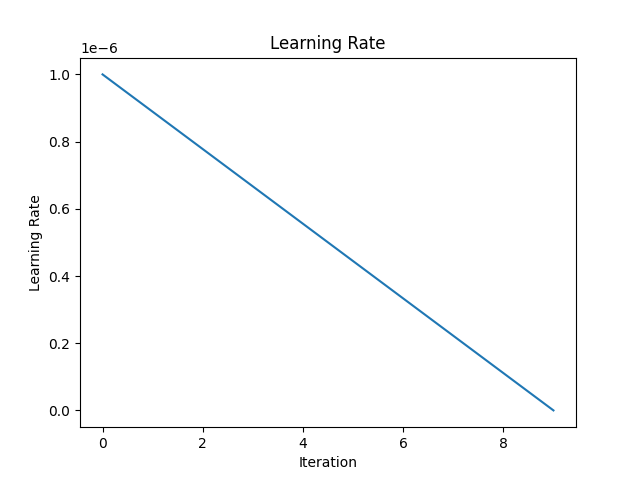
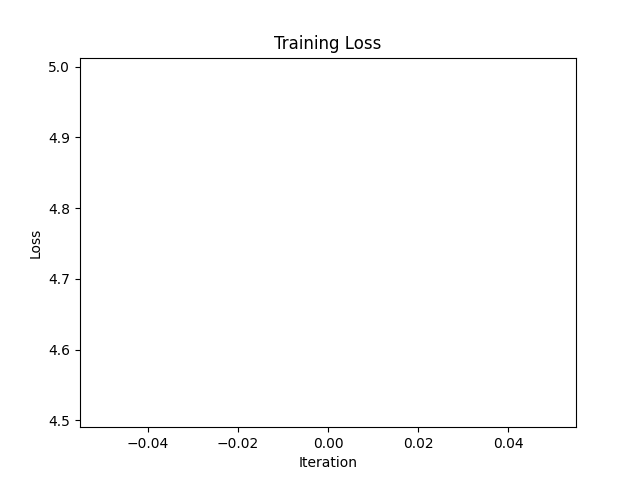
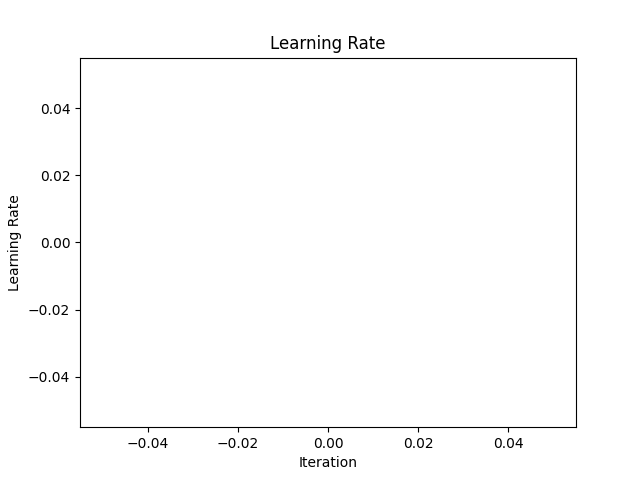
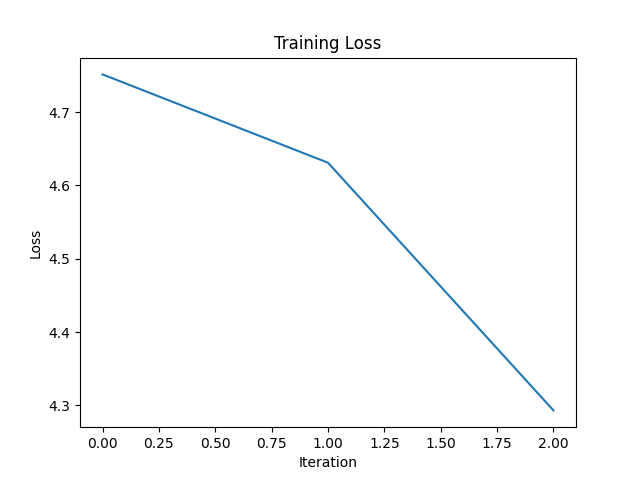
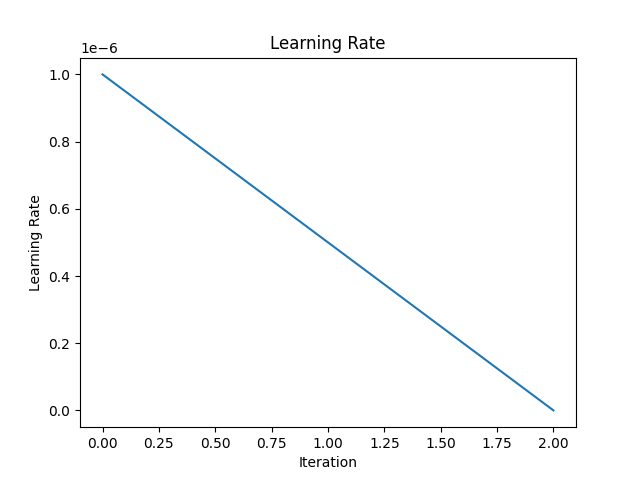
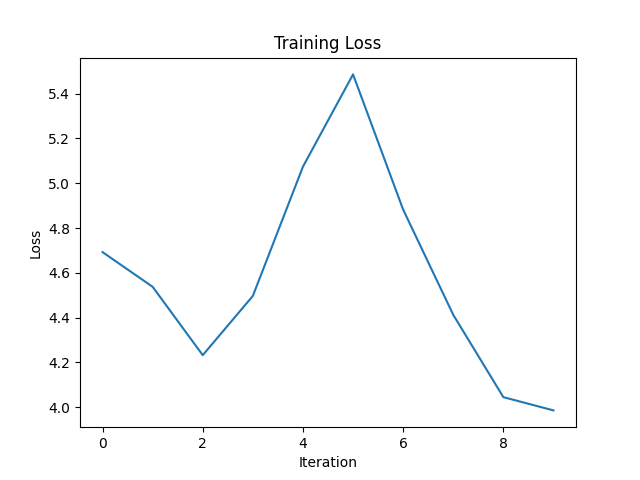
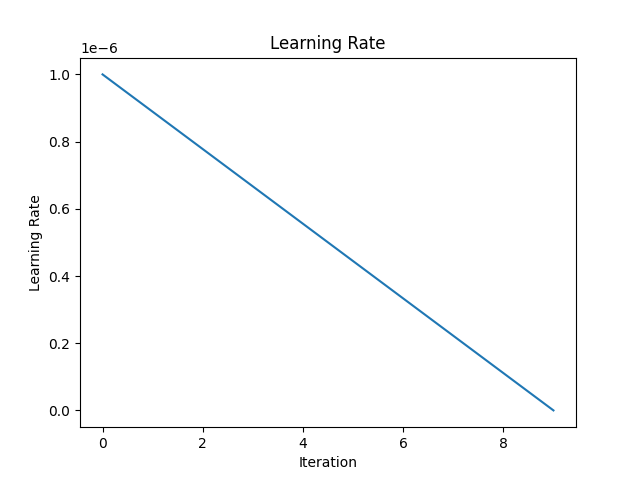
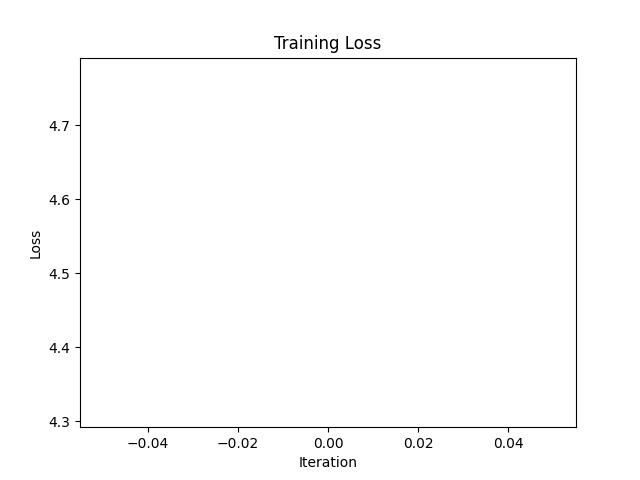
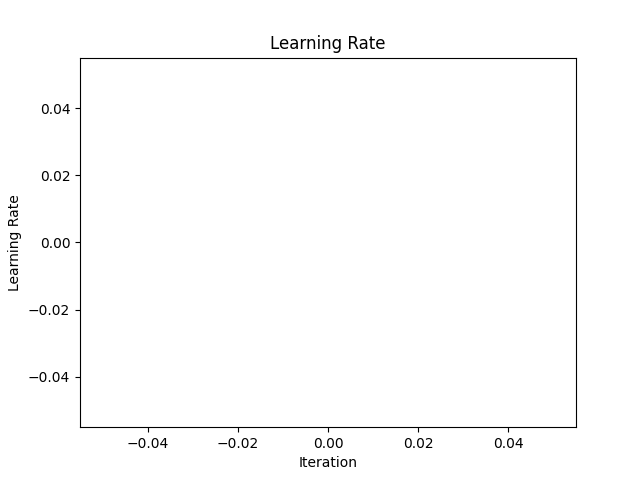
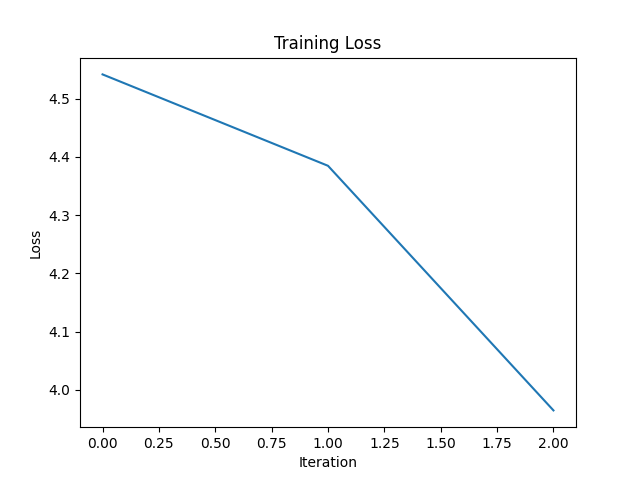
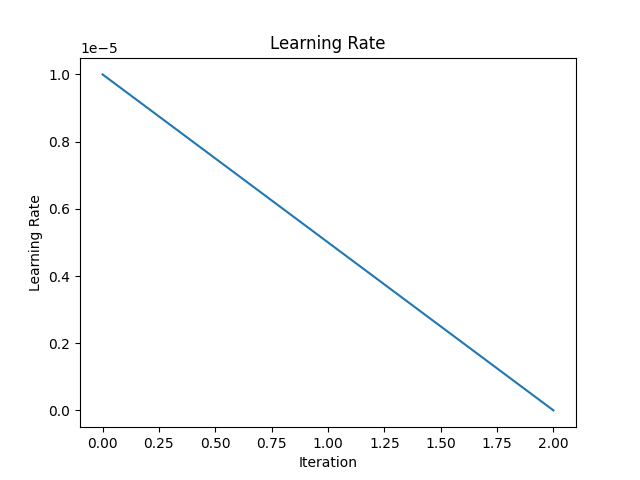
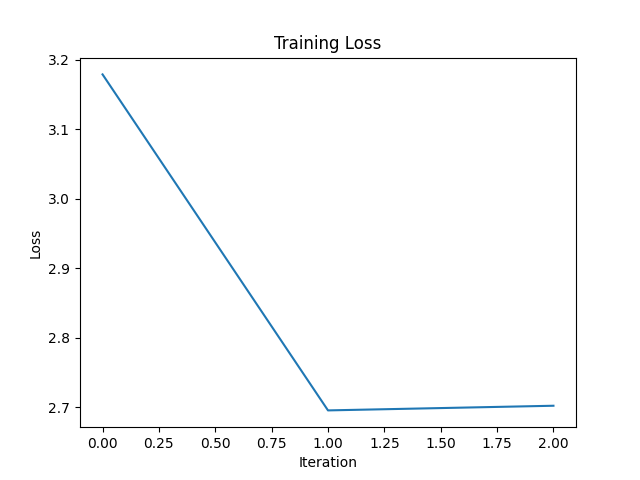
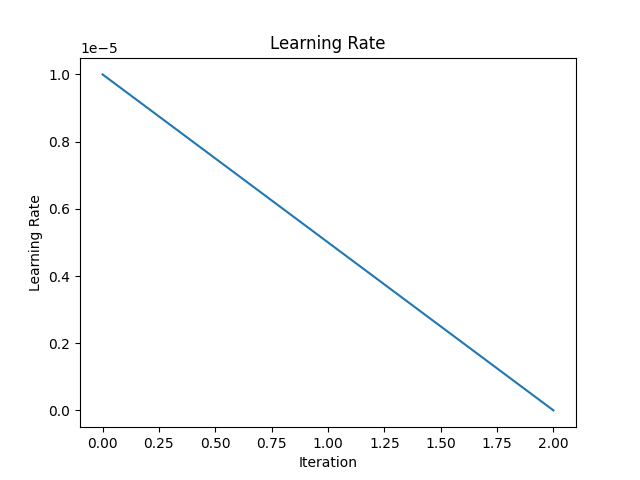
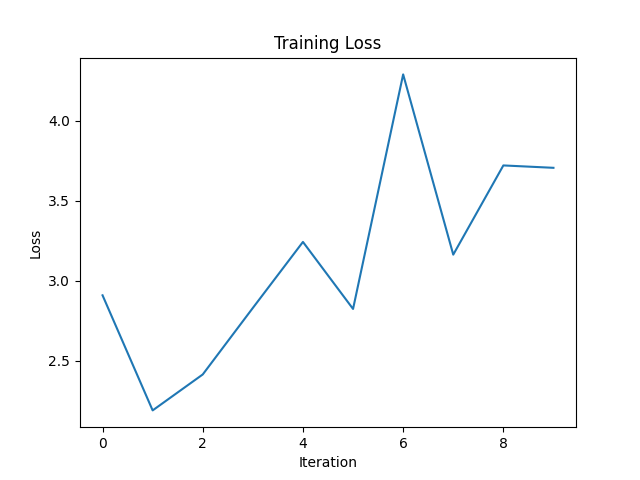
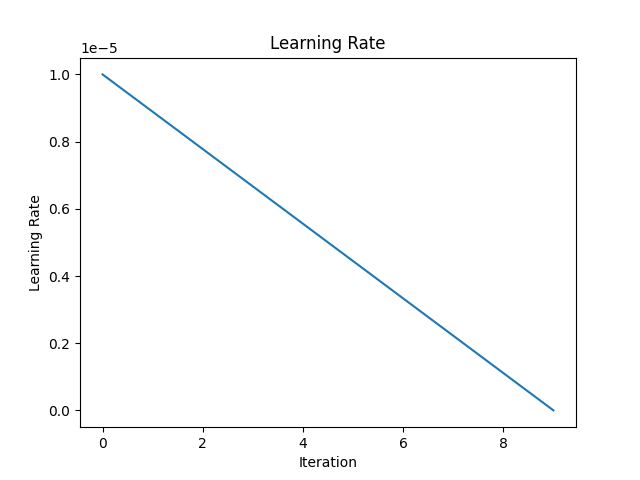
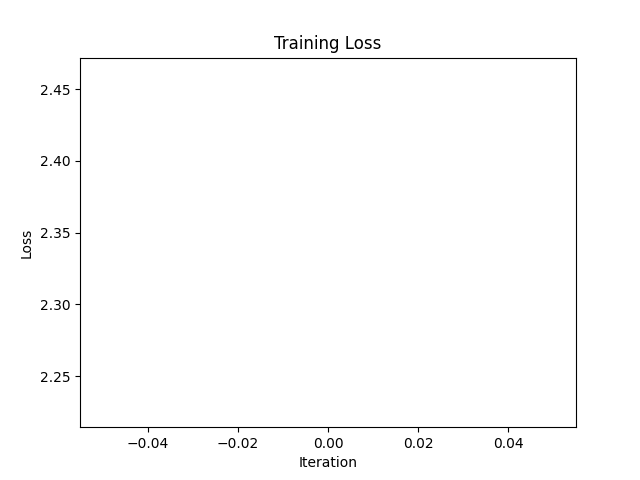
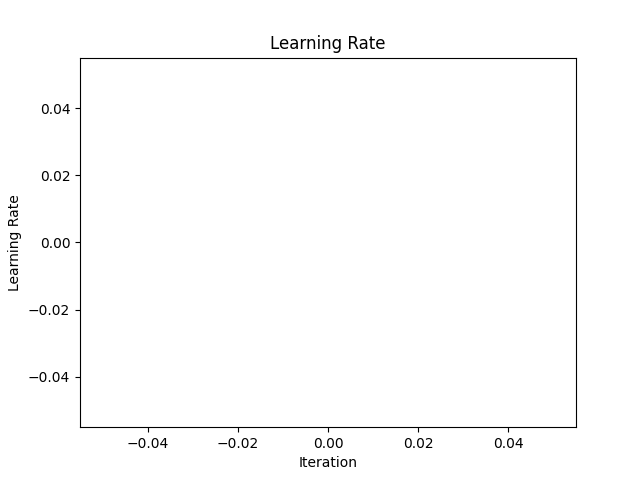
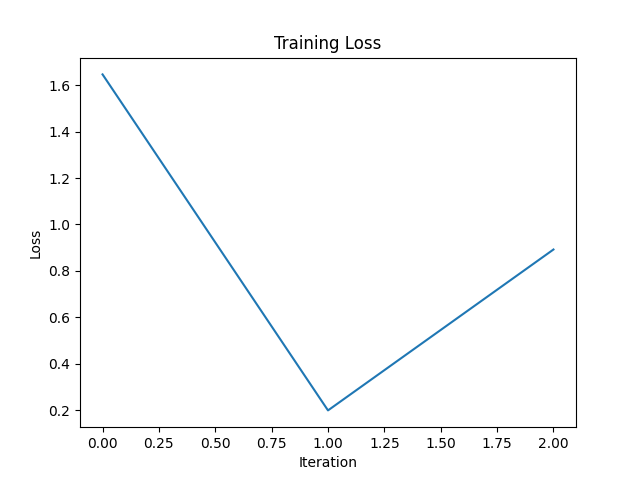
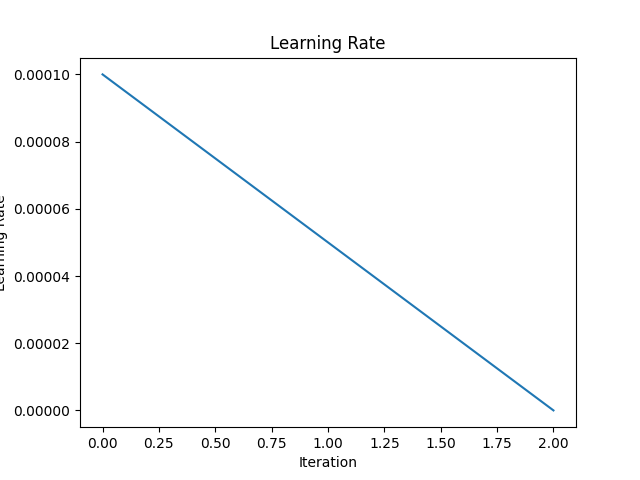
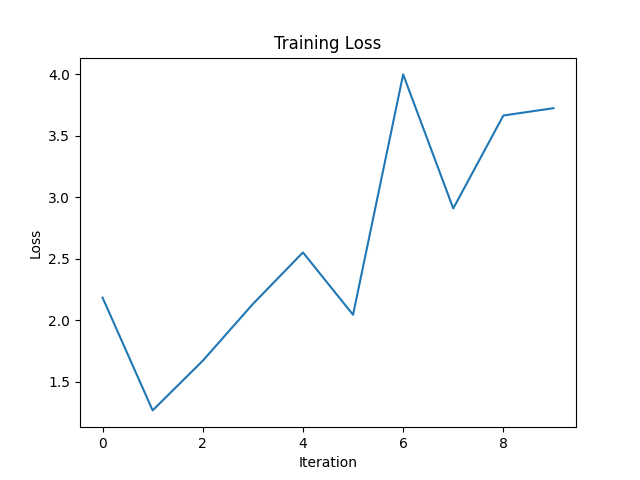
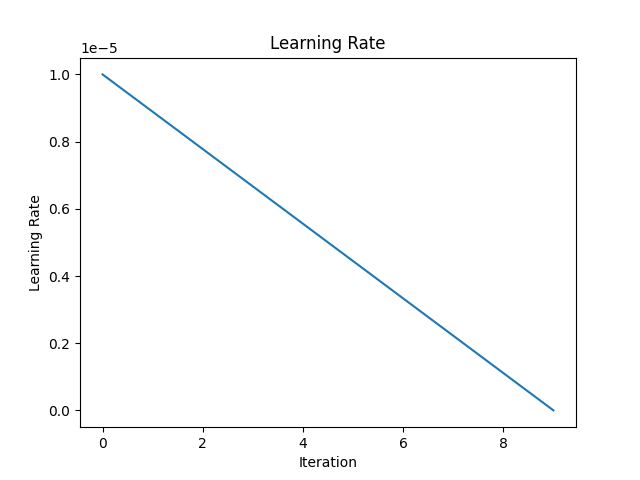
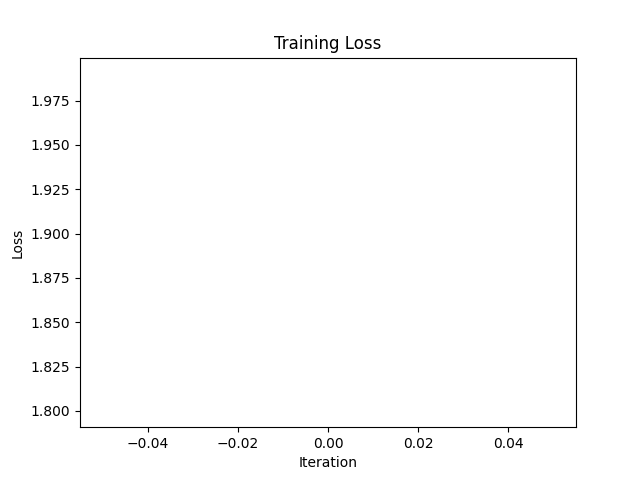
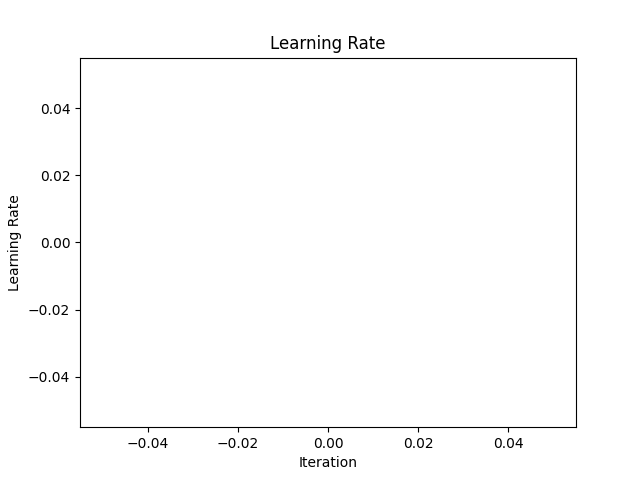
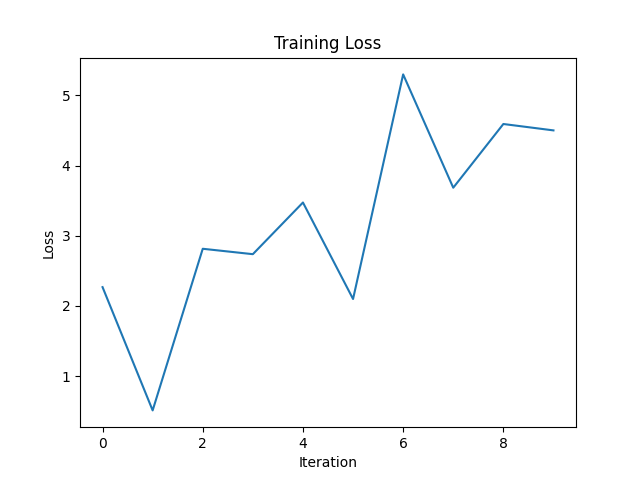
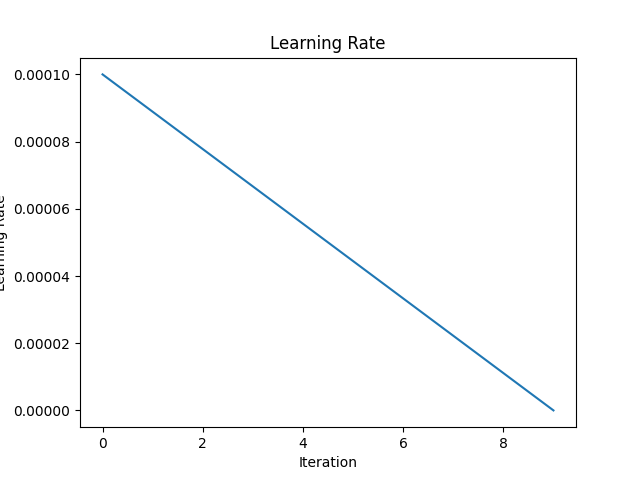
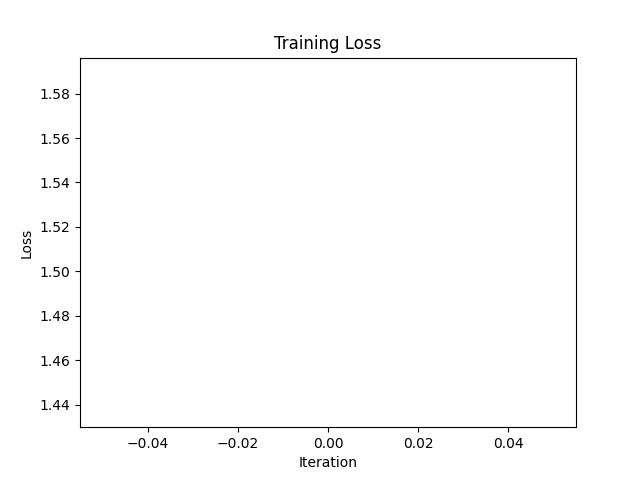
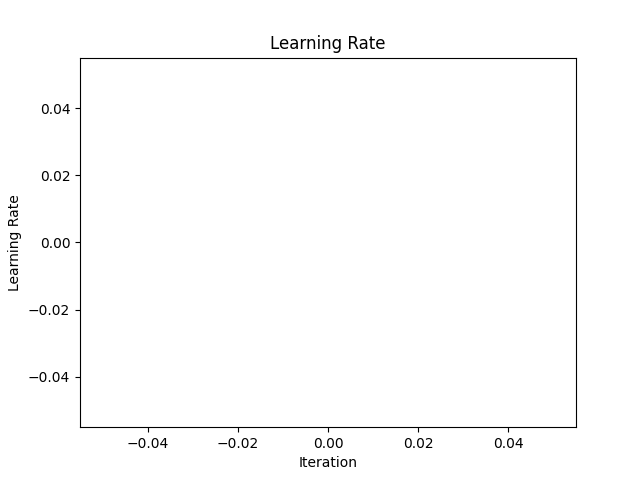
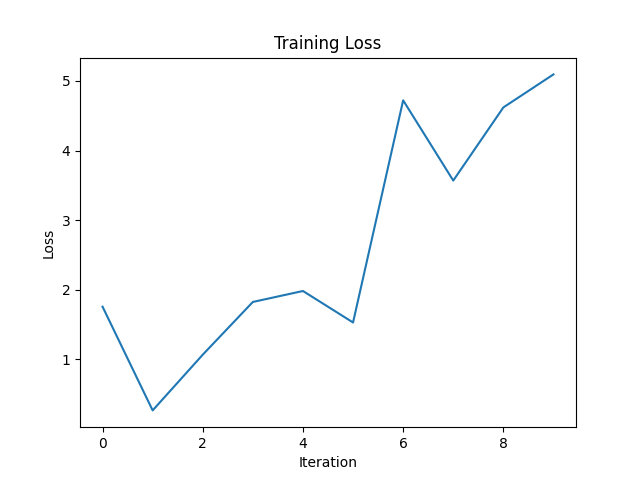
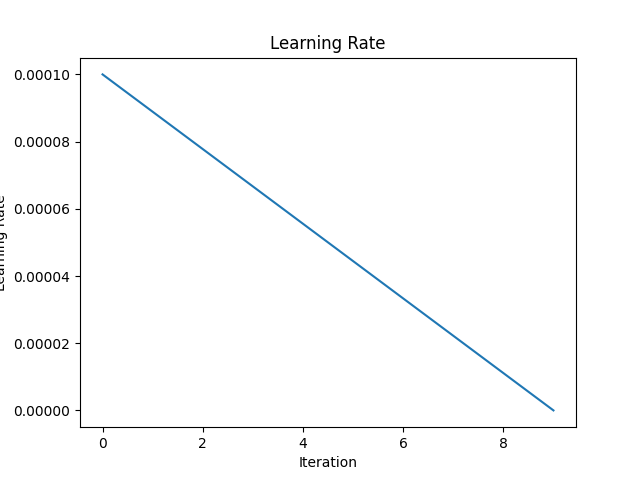
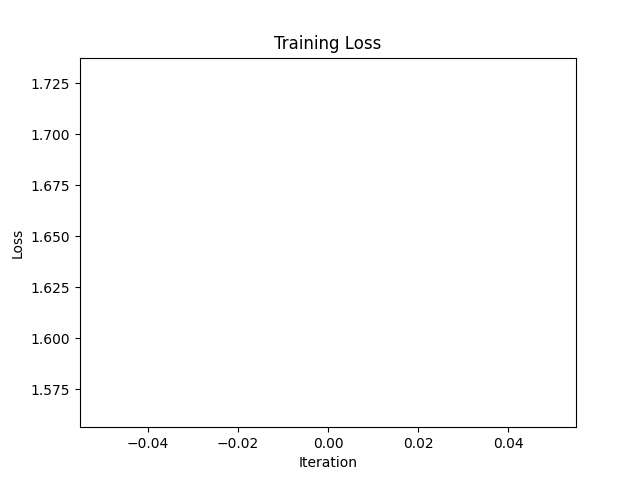
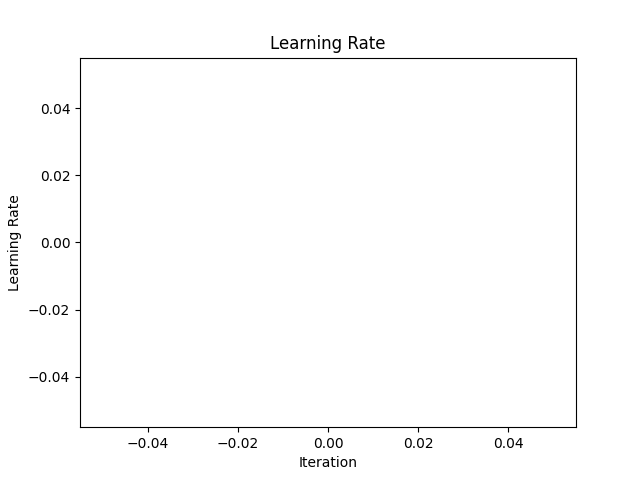
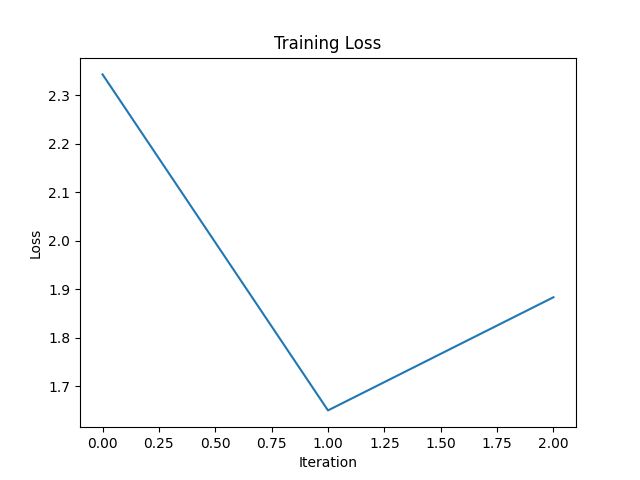
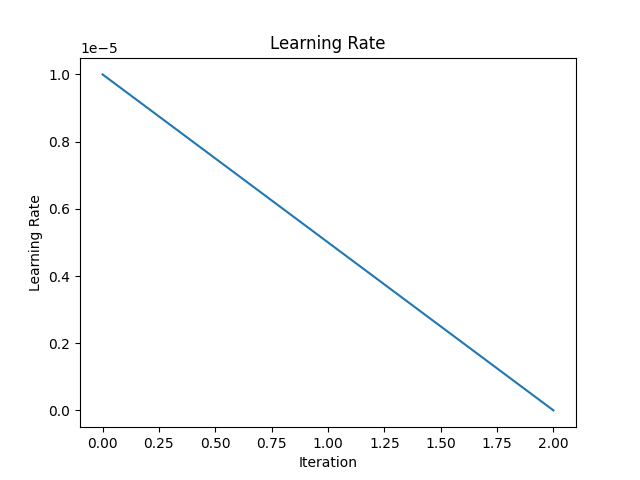
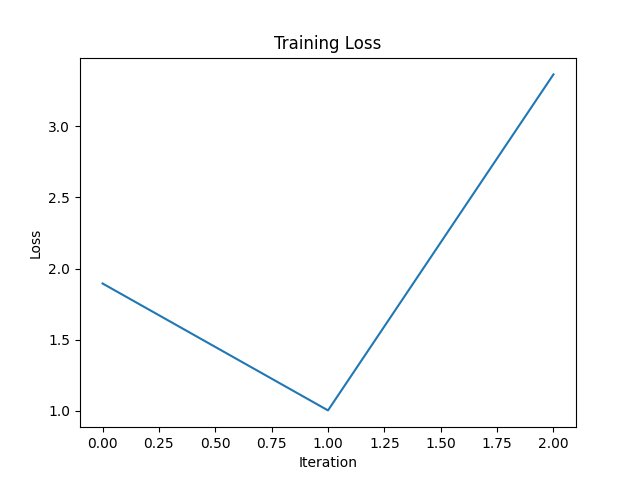
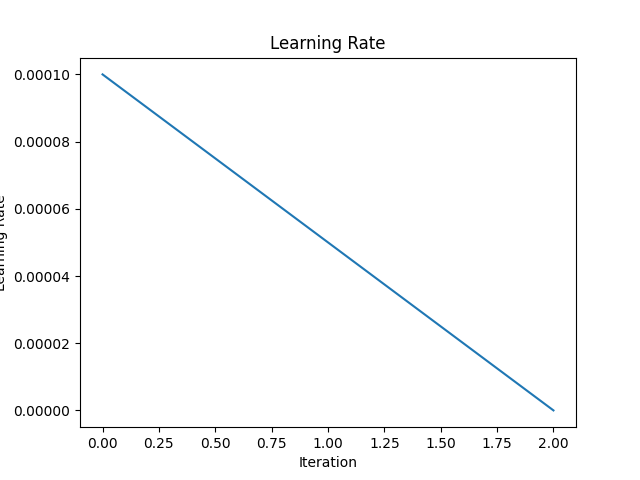
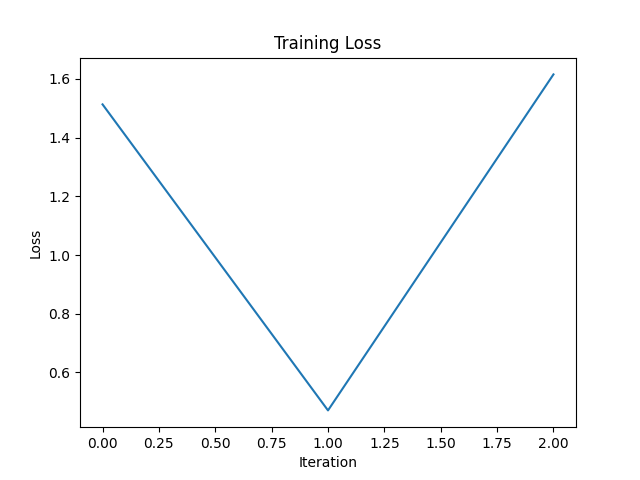
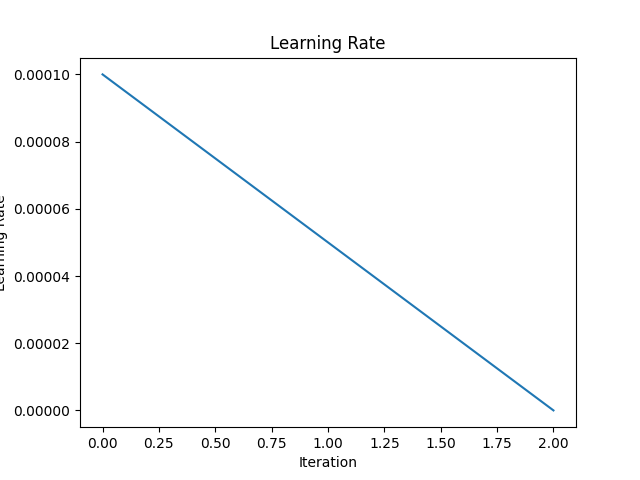
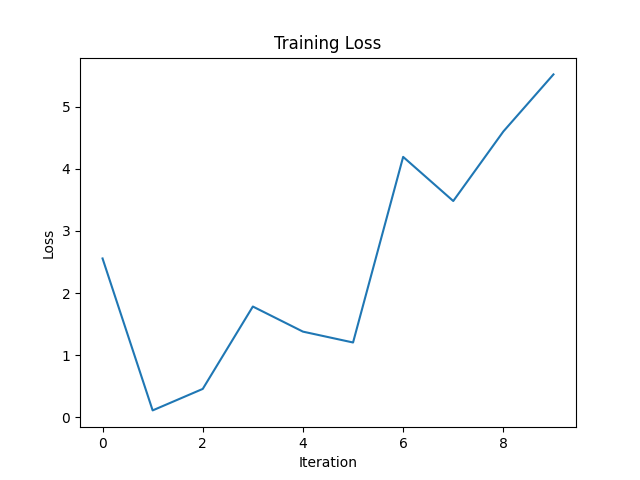
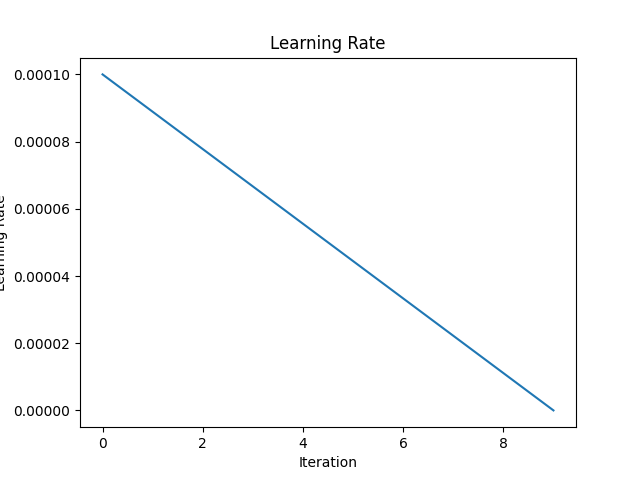

In [25]:
import pandas as pd
from IPython.display import display, HTML

# Assuming df_cos is a DataFrame with the relevant columns
dataframe = df_cos[["Image Loss", "Image Learning Rate", "Cosine Similarity", "Prediction"]]

def truncate_prediction(text):
    """Truncates text to a maximum of 200 characters and adds an ellipsis."""
    return text[:200] + "..." if len(text) > 200 else text

# Apply the truncate_prediction function to the "Prediction" column
dataframe['Prediction'] = dataframe['Prediction'].apply(truncate_prediction)

max_width = '200px'  # Adjust as needed for your desired width
s = dataframe.style
s = s.set_properties(subset='Prediction', **{
       'white-space': 'normal',
       'word-wrap': 'break-word',
       'max-width': max_width  # Adjust as needed
})

html_styler = s.to_html(escape=False)
print("\nMethod 2 (Styler object):")
display(HTML(html_styler))